In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
import os
from tqdm import tqdm

# Add the project root
sys.path.append(os.path.abspath('../../'))

from src.useful_functions import read_dirs_paths
from src.mokito.modules import *

# For matplotlib
font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# Read directory paths
read_dirs_paths('dir_paths.txt', globals())

from src.isokann.modules3 import *
import torch as pt
device = pt.device("cuda" if pt.cuda.is_available() else "cpu")

Created variables:
out_trajectories = output/trajectories/
out_isokann = output/isokann/
out_mokito = output/mokito/


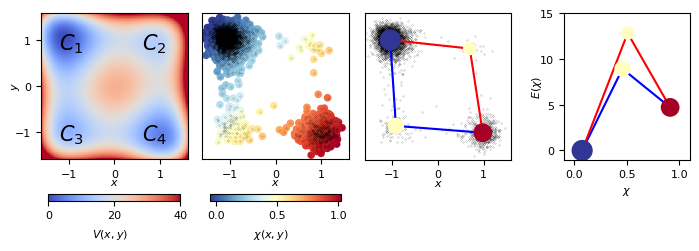

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean
import pickle
import networkx as nx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

font = {'size'   : 8}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# Load initial states 
X0     = np.load(out_trajectories + 'X0.npy')
Npoints = len(X0)

# Load potential
X, Y, V = np.load(out_trajectories + 'potential.npy')

# Load chi
chi     = np.load(out_isokann + 'chi0.npy')

# load graph object from file
G = nx.read_gml(out_mokito + "MKM.gml")

# Load energy graph elements
with open(out_mokito + "energy_MKM.npy", 'rb') as f:
    chi_nodes      = np.load(f)
    energy         = np.load(f)
    nodes_size     = np.load(f)
    index_chi_node = np.load(f)
    X_nodes        = np.load(f)

# Load chi-function
import pickle 

with open(out_isokann + 'hyperparameters.pkl', 'rb') as file:
    best_hyperparams = pickle.load(file)

nodes     = best_hyperparams['nodes']
act_fun   = best_hyperparams['act_fun']
f_NN = NeuralNetwork( Nodes =nodes, activation_function = act_fun).to(device)
f_NN.load_state_dict(pt.load(out_isokann  + 'f_NN.pt'))


fig, ax = plt.subplots(1, 4, figsize=(16*in2cm, 6*in2cm), facecolor='white')

pos = ax[0].pcolor(X, Y, V - np.min(V), shading='auto', vmax=40, cmap = 'coolwarm')
#ax[0].set_title('(a) Potential')
ax[0].set_aspect('equal', 'box')
ax[0].set_xlabel(r'$x$',labelpad=-1)
ax[0].set_ylabel(r'$y$',labelpad=-5)
ax[0].set_ylim((-1.6,1.6))
ax[0].set_xlim((-1.6,1.6))


fig.colorbar(pos, ax=ax[0], location='bottom',shrink=0.9)
ax[0].text(-0.5,-3.3, r'$V(x,y)$')

##################
pos = ax[1].scatter( X0[:,0], X0[:,1], c = chi,  cmap = cm.RdYlBu_r , s = 20 )
ax[1].plot( X0[:,0], X0[:,1], 'ko', markersize=0.1 )
ax[1].set_position([0.1, 0.6, 0.4, 0.3])
ax[1].set_aspect('equal', 'box')
ax[1].set_xlabel(r'$x$',labelpad=-1)
#ax[1].set_ylabel(r'$y$')
#ax[1].set_title(r'(b) $\chi$-function')
ax[1].set_ylim((-1.6,1.6))
ax[1].set_xlim((-1.6,1.6))
ax[1].text(-0.5,-3.3, r'$\chi(x,y)$')
ax[1].set_yticks([])
fig.colorbar(pos, ax=ax[1], location='bottom', shrink=0.9)


##################
from matplotlib.patches import FancyArrowPatch

A= nx.adjacency_matrix(G).todense()

ax[2].plot( X0[:,0], X0[:,1], 'ko', markersize=0.1 ,zorder=-1)
ax[2].scatter(X_nodes[:,0], X_nodes[:,1],  s = 0.5*nodes_size, c = index_chi_node, cmap = cm.RdYlBu_r,zorder=0)

for i in range(G.number_of_nodes()):
    for j in range(i+1,G.number_of_nodes()):
        if A[i,j]>0:
            ax[2].plot([X_nodes[i,0], X_nodes[j,0]], [X_nodes[i,1], X_nodes[j,1]],  'k-', linewidth = 0.5,zorder=-1)
            #arrow = FancyArrowPatch((X_nodes[i,0],  X_nodes[i,1]), (X_nodes[j,0], X_nodes[j,1]), zorder=-1)


ax[2].set_aspect('equal', 'box')
ax[2].set_xlabel(r'$x$',labelpad=-1)
ax[2].set_ylim((-1.6,1.6))
ax[2].set_xlim((-1.6,1.6))
ax[2].set_yticks([])

##################
from matplotlib.patches import FancyArrowPatch

#

ax[3].scatter(chi_nodes, energy,  s = 0.5*nodes_size, c = index_chi_node, cmap = cm.RdYlBu_r,zorder=0)

for i in range(G.number_of_nodes()):
    for j in range(i+1,G.number_of_nodes()):
        if A[i,j]>0:
            ax[3].plot([chi_nodes[i], chi_nodes[j]], [energy[i], energy[j]], 'k-', linewidth = 0.5,zorder=-1) 
            #arrow = FancyArrowPatch((X_nodes[i,0],  X_nodes[i,1]), (X_nodes[j,0], X_nodes[j,1]), zorder=-1)
            #ax[2].add_patch(arrow)


pathA = [0, 1, 3]
ax[2].plot(X_nodes[pathA,0], X_nodes[pathA,1], 'b-', linewidth = 1.5, zorder=-1) 
ax[3].plot(chi_nodes[pathA], energy[pathA], 'b-', linewidth = 1.5, zorder=-1) 

pathB = [0, 2, 3]
ax[2].plot(X_nodes[pathB,0], X_nodes[pathB,1], 'r-', linewidth = 1.5, zorder=-1) 
ax[3].plot(chi_nodes[pathB], energy[pathB], 'r-', linewidth = 1.5, zorder=-1) 





ax[3].set_xlabel(r'$\chi$')
ax[3].set_ylabel(r'$E(\chi)$',labelpad=-3)
ax[3].set_xlim(-0.1, 1.1)
ax[3].set_ylim(-1, 15)

#ax[3].set_title('(d) Energy \n landscape')

plt.subplots_adjust(left=0, bottom=0.0, right=1, top=0.99, wspace=0.1, hspace=0.0)

ax[2].set_position([0.32, 0.295, 0.62, 0.62])
ax[3].set_position([0.83, 0.295, 0.20, 0.62])

ax[0].text(-1.2,0.8, r'$C_1$', fontsize=15, color='k')
ax[0].text(-1.2,-1.2, r'$C_3$', fontsize=15, color='k')
ax[0].text(0.6,-1.2, r'$C_4$', fontsize=15, color='k')
ax[0].text(0.6,0.8, r'$C_2$', fontsize=15, color='k')

fig.savefig("output/figures/" + 'fig1.png', format='png', dpi=300, bbox_inches='tight')

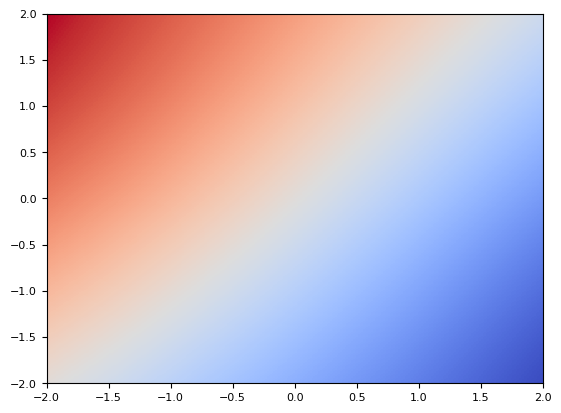

In [3]:
XY = np.column_stack((X.flatten(), Y.flatten()))
pt_XY  = pt.tensor(XY, dtype=pt.float32).to(device)

chi  =f_NN(pt_XY).cpu().detach().numpy().reshape(299,299)
plt.pcolor(X, Y, chi, shading='auto', cmap = 'coolwarm');
